# Import

In [1]:
!nvidia-smi

Fri May  5 15:03:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:01:00.0 Off |                  N/A |
| 40%   46C    P2    50W / 215W |    201MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from pathlib import Path
import cv2
import numpy as np
import shutil
import torch
from PIL import Image, ImageDraw
import sys
from ultralytics import YOLO
from typing import List, Tuple, Union
import json

print(os.getcwd())

/data2/tungtx2/datn/main_app


# Config

In [4]:
label2id = {
    'table': 0,
    'person': 1,
    'ball': 2
}
id2label = {v:k for k, v in label2id.items()}
ignore_idx = int(-1e4)

# Utils

In [6]:
def get_size(var):
    size_in_bytes = sys.getsizeof(var)

    if size_in_bytes < 1024:
        size = f"{size_in_bytes} bytes"
    elif size_in_bytes < 1024 * 1024:
        size = f"{size_in_bytes / 1024:.2f} KB"
    elif size_in_bytes < 1024 * 1024 * 1024:
        size = f"{size_in_bytes / (1024 * 1024):.2f} MB"
    else:
        size = f"{size_in_bytes / (1024 * 1024 * 1024):.2f} GB"

    return size

# Predictor

In [7]:
import os
from pathlib import Path
import cv2
from PIL import Image
from ultralytics import YOLO
from ultralytics.yolo.engine.results import Results
import numpy as np
from my_utils import *
import math
import pdb


def compute_area(row: np.array):
    xmin, ymin, xmax, ymax = row.tolist()
    w = xmax - xmin
    h = ymax - ymin
    return w * h


def compute_dist(pt1: tuple, pt2: tuple) -> float:
    """
    Computes the Euclidean distance between two points in 2D space.

    INPUT:
        :param pt1: A tuple representing the (x, y) coordinates of the first point.
        :type pt1: tuple[float, float]
        :param pt2: A tuple representing the (x, y) coordinates of the second point.
        :type pt2: tuple[float, float]
        :return: The distance between the two points.
        :rtype: float
    """
    return math.sqrt((pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2)



def approx_tab_contour(tab_contour):
    alpha = 0.01
    epsilon = alpha * cv2.arcLength(tab_contour, True)
    tab_contour = cv2.approxPolyDP(tab_contour, epsilon, True)
    tab_contour = tab_contour.reshape(-1, 2)
    while len(tab_contour) > 4 and alpha < 0.1:
        alpha += 0.01
        epsilon = alpha * cv2.arcLength(tab_contour, True)
        tab_contour = cv2.approxPolyDP(tab_contour, epsilon, True)
        tab_contour = tab_contour.reshape(-1, 2)
        # assert len(table_contour) == 4, f"approx should have 4 points, but got {len(table_contour)}"
    return tab_contour


def find_nearest_ball(ball_bbs, last_ball_pos):
    ls_pos = [((bb[0] + bb[2]) // 2, (bb[1] + bb[3]) // 2) for bb in ball_bbs]
    ls_dist = [compute_dist(pos, last_ball_pos) for pos in ls_pos]
    min_idx = np.argmin(ls_dist)
    return ball_bbs[min_idx]


class Predictor:
    def __init__(self, model_fp):
        self.model = YOLO(model_fp)
        self.id2label = self.model.names
        self.label2id = {v: k for k, v in self.id2label.items()}


    def predict(self, infer_cfg, use_last_ball_pos=False):
        raw_res = self.model.predict(**infer_cfg)
        last_ball_pos = None
        for res in raw_res:
            processed_res = self.process_res(res, last_ball_pos)
            _, _, ball_pos, _ = processed_res
            if use_last_ball_pos:
                last_ball_pos = ball_pos
            yield processed_res
    

    def predict_and_save(self, infer_cfg, save_dir):
        os.makedirs(os.path.join(save_dir, 'results'), exist_ok=True)
        processed_res_stream = self.predict(infer_cfg)
        frame_idx = 0
        for frame, table_contour, ball_pos, person_bbs in processed_res_stream:
            frame_idx += 1
            save_fp = os.path.join(save_dir, 'results', f'{frame_idx:05d}.txt')
            with open(save_fp, 'w') as f:
                if table_contour is not None and len(table_contour) == 4:
                    cv2.drawContours(frame, [table_contour], -1, (0, 255, 0), 2)
                    x1, y1, x2, y2, x3, y3, x4, y4 = table_contour.reshape(-1).tolist()
                    f.write(f'0 {x1} {y1} {x2} {y2} {x3} {y3} {x4} {y4}\n')
                if person_bbs is not None:                
                    for bb in person_bbs:
                        xmin, ymin, xmax, ymax = bb
                        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
                        f.write(f'1 {xmin} {ymin} {xmax} {ymax}\n')
                if ball_pos is not None:
                    cx, cy = ball_pos
                    cv2.circle(frame, (cx, cy), 10, (0, 0, 255), -1)
                    f.write(f'2 {cx} {cy}\n')
            
            cv2.putText(frame, f'{frame_idx:05d}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)       # draw frame_idx at top left
            cv2.imwrite(os.path.join(save_dir, 'results', f'{frame_idx:05d}.jpg'), frame)
            print(f'saved {frame_idx:05d}')


    def process_res(self, res: Results, last_ball_pos=None, remove_umpire=True):
        """
            r is a single Result object. Each contains the following attributes:
                boxes: ultralytics.yolo.engine.results.Boxes object
                    data: tensor([[429.6754, 541.3815, 449.2957, 560.9753,   0.6765,   0.0000]])
                    cls: tensor([0.])
                    conf: tensor([0.6765])
                    data: tensor([[429.6754, 541.3815, 449.2957, 560.9753,   0.6765,   0.0000]])
                    id: None
                    is_track: False
                    orig_shape: tensor([1080, 1920])
                    shape: torch.Size([1, 6])
                    xywh: tensor([[439.4855, 551.1785,  19.6203,  19.5938]])
                    xywhn: tensor([[0.2289, 0.5104, 0.0102, 0.0181]])
                    xyxy: tensor([[429.6754, 541.3815, 449.2957, 560.9753]])
                    xyxyn: tensor([[0.2238, 0.5013, 0.2340, 0.5194]])
                    
                keypoints: None
                keys: ['boxes']
                masks: None
                    data <class 'torch.Tensor'>:
                        shape: (number_of_segmented_objects, height, width)
                        each element along axis 0 is a [0, 1] mask for the corresponding object
                        height, width is the same as the input image (resized to 640)
                    orig_shape <class 'tuple'>: original shape of the input image before resizing
                    segments <class 'list'>:
                        len: number_of_segmented_objects
                        shape of each element: np.array, (number_of_segmented_points_for_each_object, 2)
                    shape <class 'torch.Size'>
                    xy <class 'list'>:
                        the same as segments
                    xyn <class 'list'>:
                        the same as segments, but normalized to [0, 1]

                names: {0: 'table', 1: 'person'}
                orig_img: np.array, the origin img
                orig_shape: (1080, 1920)
                path: '/data2/tungtx2/datn/yolov8/test.jpg'
                probs: None
                speed: {'preprocess': 1.0058879852294922, 'inference': 812.0763301849365, 'postprocess': 34.50298309326172}
        """
        if res.masks is None or res.boxes is None:
            return res.orig_img, None, None, None
        
        boxes = res.boxes.data.cpu().numpy()
        segments = res.masks.xy

        table_contour = self.find_table(boxes, segments)
        person_bbs = self.find_person(boxes, remove_umpire=remove_umpire)
        ball_pos = self.find_ball(boxes, last_ball_pos=last_ball_pos)
        
        return res.orig_img, table_contour, ball_pos, person_bbs
    

    def find_table(self, boxes, segments):
        """
            OUTPUT: np.array(shape=(4, 2)): 4 góc của table
            LOGIC:
            + if there is 1 table, return that table
            + if there are more than 1 tables, return one with largest area
        """
        tab_indices = np.where(boxes[:, -1] == self.label2id['table'])[0]
        if len(tab_indices) <= 0:
            return None
        
        if len(tab_indices) == 1:
            tab_idx = tab_indices[0]
        else:
            tab_contours = [segments[idx].astype(int) for idx in tab_indices]
            tab_areas = [cv2.contourArea(contour) for contour in tab_contours]
            tab_idx = np.argmax(tab_areas)
        tab_contour = segments[tab_idx].astype(int)
        return approx_tab_contour(tab_contour)
    

    def find_person(self, boxes: np.array, remove_umpire=True) -> np.array:
        """
            OUTPUT: np.array(shape(n, 4)): bounding box của n người
            LOGIC:
            + find bbs that are person in boxes
            + if there are 2 or fewer than 2 person, return the person_bbs as-is
            + if there are more than 2 person:
              + if remove_umpire: return only 2 boxes with largest area
              + if not remove_umpire: return the person_bbs as-is
        """
        ls_person_idx = np.where(boxes[:, -1] == self.label2id['person'])[0]
        if len(ls_person_idx) <= 0:
            return None
        
        person_bbs = boxes[ls_person_idx, :4].astype(int)
        if len(person_bbs) > 2 and remove_umpire:   # let's remove the umpire
            person_areas = np.apply_along_axis(compute_area, axis=1, arr=person_bbs)
            max_area_indices = np.argsort(person_areas)[-2:]    # take 2 indices what has the largest area
            person_bbs = person_bbs[max_area_indices]
        return person_bbs.astype(int)
    

    def find_ball(self, boxes: np.array, last_ball_pos:Tuple[int, int]=None) -> Tuple[int, int]:
        """
            OUTPUT: tọa độ tâm bóng dưới dạng 1 tuple
            LOGIC:
            + nếu có 1 ball -> return ball đó
            + nếu có 2 ball trở lên
              + nếu dùng last_ball_pos -> return vị trí ball mà gần với last_ball_coord nhất
                Với giả sử rằng vị trí ball ở 2 frame liên tiếp có ball là gần nhâu
              + nếu ko dùng last_ball_pos -> return ball có confidence_score cao nhất
        """
        ball_indices = np.where(boxes[:, -1] == self.label2id['ball'])[0]
        if len(ball_indices) <= 0:
            return None
        
        if len(ball_indices) == 1:
            ball_idx = ball_indices[0]
            ball_bb = boxes[ball_idx]
        else: 
            ball_bbs = boxes[ball_indices]
            if last_ball_pos is None:
                ball_idx = np.argmax(ball_bbs[:, 4])      # find ball with max confidence
            else:  
                ball_bb = find_nearest_ball(ball_bbs, last_ball_pos)
        cx, cy = int(ball_bb[0] + ball_bb[2]) // 2, int(ball_bb[1] + ball_bb[3]) // 2
        ball_pos = (cx, cy)
        return ball_pos

In [6]:
model_fp = '/data2/tungtx2/datn/yolov8/runs/segment/train3/weights/best.pt'
predictor = Predictor(model_fp)
# del predictor

id2label = predictor.model.names
label2id = {label: idx for idx, label in id2label.items()}
print(json.dumps(label2id, indent=4))
print(json.dumps(id2label, indent=4))

{
    "table": 0,
    "person": 1,
    "ball": 2
}
{
    "0": "table",
    "1": "person",
    "2": "ball"
}


# Get game info

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter
from typing import List, Tuple


def filter_lines(lines, class_name):
    return [line for line in lines if line.strip().split()[0] == str(label2id[class_name])]  # find line starts with table class id


def get_game_info(
    vid_res_dir: str,
    limit_ball_in_table: bool = True,
    table_offset: int = 0,
    return_frame_with_no_ball: bool = False
):
    """
        INPUT:
            :param vid_res_dir: Path to directory contains all txt files holding result of a frame
            :param limit_ball_in_table: if True, only return ball position when ball is in table
            :param table_offset: offset of table contour to make it smaller / bigger
            :param return_only_valid: if True, only return frames that have ball in table

        OUTPUT: a Tuple with 2 elements
                + num total frames in video
                + A dictionary contains info of all infered frames of the game video
                    game_info[frame_idx] = {
                        'ball': [cx, cy],
                        'table': tab_coord,
                        'person': person_bbs
                    }
        
        LOGIC:
    """

    game_info = {}
    ls_txt_fp = sorted(list(Path(vid_res_dir).glob('*.txt')))
    for fp_idx, txt_fp in enumerate(ls_txt_fp):
        frame_idx = int(txt_fp.stem)
        with open(txt_fp) as f:
            lines = f.readlines()
        ball_lines = filter_lines(lines, 'ball')
        table_lines = filter_lines(lines, 'table')
        person_lines = filter_lines(lines, 'person')

        tab_coord = [int(el) for el in table_lines[0].strip().split()[1:]] if len(table_lines) > 0 else []
        person_bbs = [[int(el) for el in line.strip().split()[1:]] for line in person_lines] if len(person_lines) > 0 else []
        
        if len(ball_lines) > 0:
            ball_info = ball_lines[0]
            cx, cy = [int(el) for el in ball_info.strip().split()[1:]]
            xmin = -1e5
            xmax = 1e5
            if limit_ball_in_table and len(tab_coord) > 0:
                xmin = min(tab_coord[0], tab_coord[2], tab_coord[4], tab_coord[6])
                xmax = max(tab_coord[0], tab_coord[2], tab_coord[4], tab_coord[6])
                xmin -= table_offset   # widen table
                xmax += table_offset

            if xmin < cx < xmax:
                game_info[frame_idx] = {
                    'ball': [cx, cy],
                    'table': tab_coord,
                    'person': person_bbs
                }

        elif return_frame_with_no_ball:
            game_info[frame_idx] = {
                'ball': [ignore_idx, ignore_idx],
                'table': tab_coord,
                'person': person_bbs
            }
    
    return len(ls_txt_fp), dict(sorted(game_info.items()))

In [9]:
num_frame, game_info = get_game_info(
    vid_res_dir='/data2/tungtx2/datn/model_output/test_7_regen/results',
    return_frame_with_no_ball=False,
    limit_ball_in_table=True,
)

print(json.dumps(dict(list(game_info.items())[:1]), indent=4))

{
    "215": {
        "ball": [
            416,
            373
        ],
        "table": [
            408,
            642,
            1437,
            621,
            1302,
            468,
            531,
            468
        ],
        "person": [
            [
                1329,
                152,
                1500,
                613
            ]
        ]
    }
}


In [10]:
print(get_size(game_info))
print(len(game_info))
print(num_frame)

144.11 KB
5205
15600


# Get extrema x and maxima y

In [9]:
#doc: extract extrema points for both x and y-axis
smooth = False
frame_w, frame_h = 1920, 1080
frame_range = (0, 3600)

# extrema_x params
distance_x = 50  # khoảng cách về mặt thời gian giữa 2 cực trí, xấp xỉ khoảng thời gian để vợt chạm bóng -> bóng đi sang bên kia -> bóng nảy lại tới vợt
prominence_x = 300   # độ nhô cao của cực trị, xấp xỉ chiều dài bàn tính bằng pixel (vì bóng nảy từ bên này sang bên kia bàn)
width_x = 5  # độ rộng của cực trị, thường lấy ở giữa độ cao của cục trị đó => xấp xỉ thời gian (tính bằng số frame có bóng) để quả bóng đi từ giữa bàn -> cuối bàn -> nảy lại giữa bàn
wlen_x = None   # khung thời gian để tính prominence,

# maxima_y params
distance_y = 10  # thời gian giữa 2 lần bóng đâp bàn liên tiếp tạo thành cực đại. Nhỏ như vậy để bắt được giao bóng
prominence_y = 10  # độ cao tối thiểu khi bóng đập bàn nảy lên
width_y = 5  # thời gian để bóng gần chạm vào bàn -> chạm bàn -> nảy lên
wlen_y = 20  # khung thời gian để tính prominence,

# smooth params
savgol_filter_x = 31
polyorder_x = 3
savgol_filter_y = 11
polyorder_y = 1

ls_frame_idx, ls_ball_cx, ls_ball_cy = [], [], []
for fr_idx, ball_trajectory in game_info.items():
    if fr_idx < frame_range[0] or fr_idx > frame_range[1]:
        continue
    ls_frame_idx.append(fr_idx)
    ls_ball_cx.append(ball_trajectory['ball'][0])
    ls_ball_cy.append(ball_trajectory['ball'][1])

if smooth:
    ls_ball_cx = savgol_filter(ls_ball_cx, savgol_filter_x, polyorder_x)
    ls_ball_cy = savgol_filter(ls_ball_cy, savgol_filter_y, polyorder_y)
    

maxima_x = find_peaks(ls_ball_cx, distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
minima_x = find_peaks(-np.array(ls_ball_cx), distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
maxima_y = find_peaks(ls_ball_cy, distance=distance_y, prominence=prominence_y, width=width_y, wlen=wlen_y)[0].tolist()

real_maxima_x = sorted([ls_frame_idx[el] for el in maxima_x])
real_minima_x = sorted([ls_frame_idx[el] for el in minima_x])
real_maxima_y = sorted([ls_frame_idx[el] for el in maxima_y])

print(f'In frame range {frame_range}, there are {len(ls_frame_idx)} frames with ball')
print('Ball hits at frames: ', sorted(real_maxima_x + real_minima_x))
print('Ball bounces at frames: ', real_maxima_y)

In frame range (0, 3600), there are 1490 frames with ball
Ball hits at frames:  [418, 1091, 1148, 1857, 2353, 2497, 2584, 2643, 2709, 2783, 2811, 3412]
Ball bounces at frames:  [236, 311, 379, 435, 892, 1016, 1063, 1135, 1178, 1870, 1928, 1978, 2031, 2066, 2305, 2421, 2473, 2554, 2622, 2689, 2752, 2807, 2885, 2914, 2944, 2972, 3415]


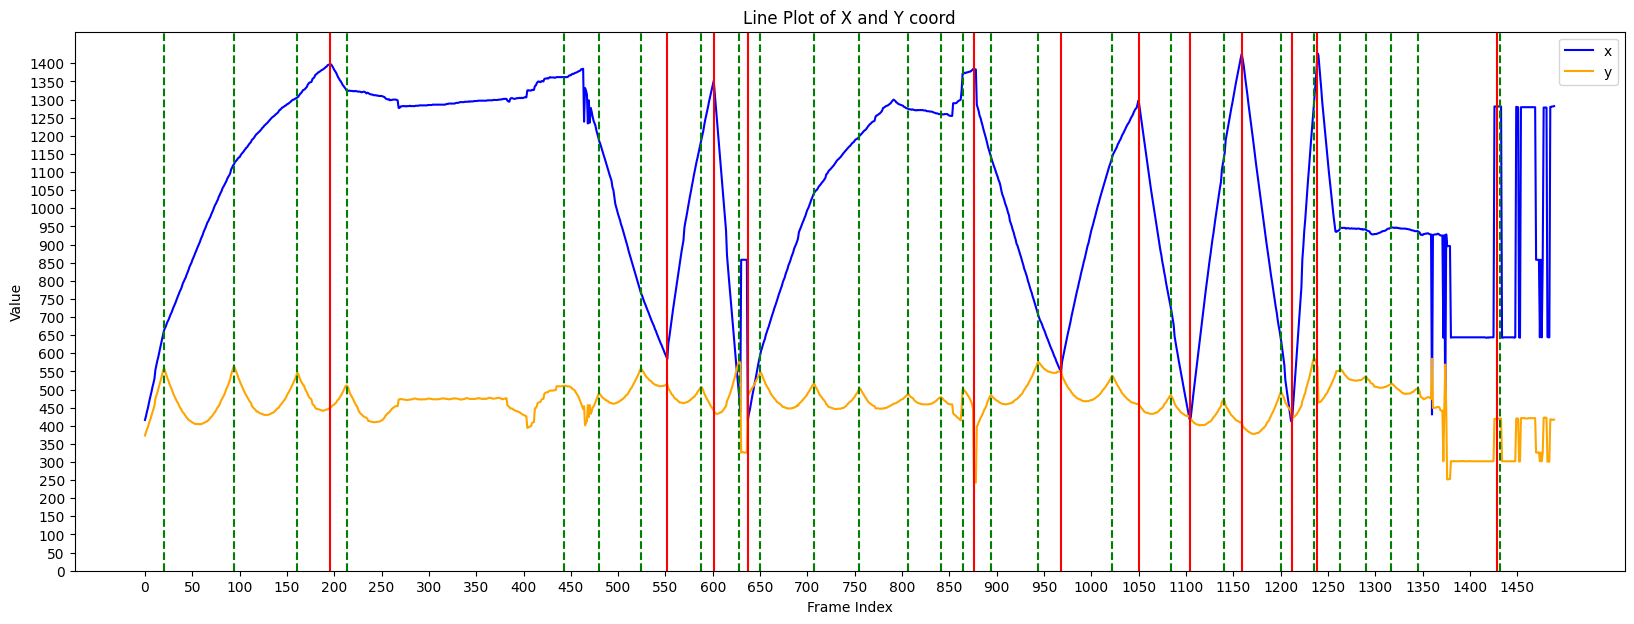

maxima_x and real_maxima_x:  [(196, 418), (601, 1148), (876, 2353), (1050, 2584), (1159, 2709), (1239, 2811), (1429, 3412)]

minima_x and real_minima_x:  [(552, 1091), (637, 1857), (968, 2497), (1104, 2643), (1212, 2783)]

maxima_y and real_maxima_y:  [(20, 236), (94, 311), (161, 379), (213, 435), (443, 892), (480, 1016), (524, 1063), (588, 1135), (628, 1178), (650, 1870), (707, 1928), (755, 1978), (806, 2031), (841, 2066), (864, 2305), (894, 2421), (944, 2473), (1022, 2554), (1084, 2622), (1140, 2689), (1200, 2752), (1235, 2807), (1263, 2885), (1290, 2914), (1317, 2944), (1345, 2972), (1432, 3415)]


In [10]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 7))

# plot ball position
ax.plot(ls_ball_cx, color='blue', label='x')
ax.plot(ls_ball_cy, color='orange', label='y')

# plot extrema
for index in maxima_x + minima_x:
    ax.axvline(x=index, color='r', linestyle='-')
for index in maxima_y:
    ax.axvline(x=index, color='g', linestyle='--')

# Set the title, axis labels, and legend
ax.set_title("Line Plot of X and Y coord")
ax.set_xlabel("Frame Index")
ax.set_ylabel("Value")
ax.legend()

# set xtick 
x_range = range(0, len(ls_ball_cx), 50)
ax.set_xticks(x_range)
y_range = range(0, max(ls_ball_cx), 50)
ax.set_yticks(y_range)

# Show the plot
plt.show()
fig.savefig('figures/1.jpg')


print('maxima_x and real_maxima_x: ', list(zip(maxima_x, real_maxima_x)), end='\n\n')
print('minima_x and real_minima_x: ', list(zip(minima_x, real_minima_x)), end='\n\n')
print('maxima_y and real_maxima_y: ', list(zip(maxima_y, real_maxima_y)), end='\n')

# Serve detection by ball bounce

In [ ]:
#docs: serve detection by ball bounce
real_extrema_x_idx = sorted(real_maxima_x + real_minima_x)
real_extrema_x_idx = [ls_frame_idx[0]] + real_extrema_x_idx + [ls_frame_idx[-1]]
nbounce2type = {
    0: 'out',
    1: 'valid',
    2: 'serve',
    3: 'invalid'
}

def get_median_table_coord(game_info: dict, start_frame_idx: int, end_frame_idx: int) -> List[int]:
    coords = np.zeros((0, 4))
    for k, v in game_info.items():
        if len(v['table']) > 0 and (not start_frame_idx <= k <= end_frame_idx):
            coords = np.vstack([coords, v['table']])
    return list(np.median(coords, axis=0))


for i in range(len(real_extrema_x_idx)-1):
    start_fr_idx = real_extrema_x_idx[i]
    end_fr_idx = real_extrema_x_idx[i+1]
    # print(f'start: {start_idx}, end: {end_idx}')
    
    # check valid ball x-axis coord: ball must go from one side to other side of the table
    tab_xmin, _, tab_xmax, _ = get_median_table_coord(game_info, start_fr_idx, end_fr_idx)
    # print(f'end_x: {end_x}, start_x: {start_x}, tab_xmin: {tab_xmin}, tab_xmax: {tab_xmax}')
    start_x_coord = game_info[start_fr_idx]['ball'][0]
    end_x_coord = game_info[end_fr_idx]['ball'][0]
    if abs(end_x_coord - start_x_coord) < (tab_xmax - tab_xmin) * 0.6:
        print(f'Checking frame {start_fr_idx}-{end_fr_idx}: ball not travel full table')
        continue
    
    # ball fly time from one side to the other should be smaller than 2s = 240frame 
    if end_fr_idx - start_fr_idx > 240:
        print(f'Checking frame {start_fr_idx}-{end_fr_idx}: ball fly time exceed')
        continue
        
    # check how many idx in ls_bounce_idx are in between start and end
    n_bounce = len([el for el in real_maxima_y if start_fr_idx < el < end_fr_idx])
    n_bounce = min(3, n_bounce)
    if n_bounce == 2:
        print(f'Checking frame {start_fr_idx}-{end_fr_idx}: SERVE DETECTED')
    elif n_bounce == 0:
        print(f'Checking frame {start_fr_idx}-{end_fr_idx}: OUT DETECTED')
    else:
        print(f'Checking frame {start_fr_idx}-{end_fr_idx}: nothing')


# Kalman Box Tracker

In [1]:
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import glob
import time
from filterpy.kalman import KalmanFilter

In [2]:
def convert_bbox_to_z(bbox):
    """
    Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
      [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
      the aspect ratio
    """
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h  # scale is just area
    r = w / float(h)
    return np.array([x, y, s, r]).reshape((4, 1))


def convert_x_to_bbox(x, score=None):
    """
    Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
      [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
    """
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if (score == None):
        return np.array([x[0]-w/2., x[1]-h/2., x[0]+w/2., x[1]+h/2.]).reshape((1, 4))
    else:
        return np.array([x[0]-w/2., x[1]-h/2., x[0]+w/2., x[1]+h/2., score]).reshape((1, 5))


class KalmanBoxTracker:
    """
    This class represents the internal state of individual tracked objects observed as bbox.
    """
    count = 0

    def __init__(self, bbox):
        """
        Initialises a tracker using initial bounding box.
        """
        # define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1], [
                             0, 0, 0, 1, 0, 0, 0],  [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1]])
        self.kf.H = np.array([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [
                             0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0]])

        self.kf.R[2:, 2:] *= 10.
        self.kf.P[4:, 4:] *= 1000.  # give high uncertainty to the unobservable initial velocities
        self.kf.P *= 10.
        self.kf.Q[-1, -1] *= 0.01
        self.kf.Q[4:, 4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0


    def update(self, bbox):
        """
        Updates the state vector with observed bbox.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(convert_bbox_to_z(bbox))


    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate.
        """
        if ((self.kf.x[6]+self.kf.x[2]) <= 0):
            self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if (self.time_since_update > 0):
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]


    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return convert_x_to_bbox(self.kf.x)


tracker = KalmanBoxTracker((0, 0, 10, 10))
ls_ball_pos = [v['ball'] for k, v in game_info.items()]
ls_ball_pos = ls_ball_pos[:10]
ls_ball_bb = [[el[0], el[1], el[0]+10, el[1]+10] for el in ls_ball_pos]
blank_img = np.full((1080, 1920, 3), 255, dtype=np.uint8)
for bb in ls_ball_bb:
    # draw a blue circle centered at top left corner
    blank_img = cv2.circle(blank_img, (bb[0], bb[1]), 10, (255, 0, 0), -1)

    tracker.predict()
    tracker.update(bb)

for i in range(10):
    pred_bb = tracker.predict()
    blank_img = cv2.circle(blank_img, (int(pred_bb[0][0]), int(pred_bb[0][1])), 10, (0, 0, 255), -1)

cv2.imwrite('test.jpg', blank_img)

NameError: name 'game_info' is not defined

In [16]:
ls_ball_bb

[[416, 373, 426, 383],
 [426, 382, 436, 392],
 [438, 389, 448, 399],
 [448, 396, 458, 406],
 [461, 405, 471, 415],
 [473, 413, 483, 423],
 [484, 420, 494, 430],
 [495, 430, 505, 440],
 [508, 438, 518, 448],
 [518, 447, 528, 457]]

# Hightlight detection using ball state

In [59]:
class BallTracker:
    def __init__(self, fps, vid_res_dir, limit_ball_in_table, return_frame_with_no_ball):
        self.fps = fps
        self.total_fr, self.game_info = get_game_info(
            vid_res_dir,
            limit_ball_in_table=limit_ball_in_table,
            return_frame_with_no_ball=return_frame_with_no_ball
        )

        self.cx_history, self.cy_history, self.fr_indices_with_ball = [], [], []
        # self.cnt = 0
        for fr_idx, info in sorted(self.game_info.items()):
            # self.cnt += 1
            self.cx_history.append(info['ball'][0])
            self.cy_history.append(info['ball'][1])
            if info['ball'] != (ignore_idx, ignore_idx):
                self.fr_indices_with_ball.append(fr_idx)
        self.cx_history_with_ball = [el for el in self.cx_history if el != ignore_idx]
        self.cy_history_with_ball = [el for el in self.cy_history if el != ignore_idx]
            
        self.tracker = KalmanBoxTracker(bbox=[0, 0, 1, 1])

        time_check_interval = 1   # 1s
        self.fr_check_interval = time_check_interval * self.fps
        self.min_fr_with_ball_percent = 0.7
        self.min_fr_without_ball_percent = 0.7
        self.velocity_dict = {}
        self.ls_rally = []
        self.ls_rally_final = []


    def generate_hightlight(self):
        """
            Generate hightlight based on all self.history
        """
        is_started = False
        started_fr = None
        end_fr = None
        for index, fr_idx in enumerate(self.fr_indices_with_ball):
            print(f'Checking frame {fr_idx}')
            if is_started:
                is_end = self.check_end(index, fr_idx)
                if is_end:
                    is_started = False
                    end_fr = fr_idx + self.fr_check_interval
                    print(f'Ball ends at frame {end_fr}')
                    self.ls_rally.append([started_fr, end_fr])
                    started_fr, end_fr = None, None
            else:
                is_started = self.check_start(index, fr_idx)
                if is_started:
                    started_fr = fr_idx - self.fr_check_interval
                    print(f'Ball starts at frame {started_fr}')

        self.ls_rally_final = [rally for rally in self.ls_rally if self.check_valid_rally(rally[0], rally[1])]
        return self.ls_rally_final
    

    def check_start(self, index, fr_idx):
        # ------------------- 
        if min(index, fr_idx) < self.fr_check_interval:
            return False
        
        pass_min_fr_with_ball = self.check_min_fr_with_ball(index, fr_idx)
        if not pass_min_fr_with_ball:
            return False

        ball_trajectory = self.get_ball_trajectory(fr_idx, fr_idx+self.fr_check_interval) 
        pass_ball_trajectory = self.check_ball_trajectory(ball_trajectory)
        if not pass_ball_trajectory:
            return False
        

    def check_min_fr_with_ball(self, index, fr_idx):
        """
            :param index: index of the frame in the list of has-ball frames
            :param fr_idx: real index of the frame
        """
        min_fr_with_ball = int(self.min_fr_with_ball_percent * self.fr_check_interval)
        if self.fr_indices_with_ball[index+min_fr_with_ball] < fr_idx + self.fr_check_interval:
            return True
        return False
    

    def check_min_fr_without_ball(self, index, fr_idx):
        max_fr_with_ball = (1-self.min_fr_without_ball_percent) * self.fr_check_interval
        if self.fr_indices_with_ball[index + max_fr_with_ball] > fr_idx + self.fr_check_interval:
            return True
        return False


    def check_ball_trajectory(self, ball_trajectory):
        """
            ball_trajectory is in form [(fr_idx, (cx, cy)), (fr_idx, (cx, cy)), ...]
        """
        is_valid_velocity = self.check_velocity(ball_trajectory, min_valid_percent=0.7)
        if not is_valid_velocity:
            return False
        
        ls_frame_idx = [el[0] for el in ball_trajectory]
        ls_cx = [self.cx_history[fr_idx] for fr_idx in ls_frame_idx]
        is_valid_max_travel_dist = self.check_travel_dist(ls_cx, thresh=200, smooth=True)
        if not is_valid_max_travel_dist:
            return False


    def get_ball_trajectory(self, start_idx, end_idx):
        ball_trajectory = []
        for fr_idx in range(start_idx, end_idx+1):
            if fr_idx in self.fr_indices_with_ball:
                ball_trajectory.append((fr_idx, self.game_info[fr_idx]['ball']))
        return ball_trajectory
    

    def check_velocity(self, ball_trajectory, min_valid_percent=0.7):
        """
            ball_trajectory is in form [(fr_idx, (cx, cy)), (fr_idx, (cx, cy)), ...]
        """
        ls_velocity = []
        min_v_thresh = 5 * 120 / self.fps
        max_v_thresh = 50 * 120 / self.fps
        for i in range(len(ball_trajectory)-1):
            start = ball_trajectory[i]
            end = ball_trajectory[i+1]
            frame_diff = abs(end[0] - start[0])
            if (start[0], end[0]) not in self.velocity_dict:
                x1, y1, x2, y2 = start[1][0], start[1][1], end[1][0], end[1][1]
                coord_diff = math.sqrt((x1-x2)**2 + (y1-y2)**2)
                self.velocity_dict[(start[0], end[0])] = round(coord_diff / frame_diff, 2)  # đơn vị: pixel / frame
            ls_velocity.append(self.velocity_dict[(start[0], end[0])])
        
        num_valid = len([v for v in ls_velocity if max_v_thresh > v > min_v_thresh])
        return num_valid > min_valid_percent * len(ball_trajectory)


    def check_travel_dist(self, ls_cx, thresh, smooth=True):
        ls_smooth_cx = savgol_filter(ls_cx, 21, 3)  
        return abs(max(ls_smooth_cx)-min(ls_smooth_cx)) > thresh
    
    def check_end(self, index, fr_idx):
        if not self.check_min_fr_without_ball(index, fr_idx):
            return False
        return True
    
    def check_valid_rally(self, start_fr_idx, end_fr_idx, is_debug=False):
        # check duration < 2s => invalid
        if abs(end_fr_idx - start_fr_idx) < self.fps * 2:
            print(f'duration {end_fr_idx - start_fr_idx} < 200') if is_debug else None
            return False
        else:
            print(f'duration {end_fr_idx - start_fr_idx} OK') if is_debug else None
        
        
        # check if have no extrema => invalid
        ls_cx = [self.cx_history[fr_idx] for fr_idx in range(start_fr_idx, end_fr_idx+1) if fr_idx in self.fr_indices_with_ball]
        ls_cx = savgol_filter(ls_cx, 21, 3)  
        # find extrema
        distance_x = 50
        prominence_x = 300
        width_x = 5
        wlen_x = None
        maxima_x = find_peaks(ls_cx, distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
        minima_x = find_peaks(-np.array(ls_cx), distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
        # check if have no maxima or minima => invalid
        if len(maxima_x) == 0:
            print(f'num maxima = 0') if is_debug else None
            return False
        else:
            print(f'num maxima = {len(maxima_x)} OK') if is_debug else None
            
        if len(minima_x) == 0:
            print(f'num minima = 0') if is_debug else None
            return False
        else:
            print(f'num minima = {len(minima_x)} OK') if is_debug else None
        
        return True

In [ ]:
#docs: test ball tracker
tracker = BallTracker(
    fps = 120, 
    vid_res_dir='/data2/tungtx2/datn/model_output/test_7_regen/results',
    limit_ball_in_table=True,
    return_frame_with_no_ball=True
)

ls_rally_final = tracker.generate_hightlight()
print(ls_rally_final)

In [57]:
print(tracker.total_fr)
print(len(tracker.game_info.items()))
print(len(tracker.cx_history))
print(len(tracker.cx_history_with_ball))
print(len(tracker.fr_indices_with_ball))

15600
14633
14633
5205
14633


AttributeError: 'BallTracker' object has no attribute 'cnt'

In [ ]:
import pdb
import math

def is_monotonous(ls):
    num_ascend, num_descend = 0, 0
    for i in range(len(ls)-1):
        if ls[i+1] > ls[i]:
            num_ascend += 1
        elif ls[i+1] < ls[i]:
            num_descend += 1
    # print(f'num_ascend: {num_ascend}, num_descend: {num_descend}')
    if min(num_ascend, num_descend) / (num_ascend+num_descend) > 0.1:
        return False
    return True


def is_valid_velocity(info: List[Tuple[int, int]], fps=120):
    """
        info = [(frame_idx, cx), (frame_idx, cx), ...]
    """
    ls_velocity = []
    v_thresh = 5
    for i in range(len(info)-1):
        start = info[i]
        end = info[i+1]
        frame_diff = abs(end[0] - start[0])
        x1, y1, x2, y2 = start[1][0], start[1][1], end[1][0], end[1][1]
        coord_diff = math.sqrt((x1-x2)**2 + (y1-y2)**2)
        ls_velocity.append(round(coord_diff / frame_diff, 2))   # đơn vị: pixel / frame
    
    # print(ls_velocity)
    # assert 50% of velocity is greater than threshold
    num_valid = len([v for v in ls_velocity if v > v_thresh])
    return num_valid > 0.7 * len(info)
    
    
def is_valid_ball_trajectory(ls_ball_coord: List[Tuple[int, Tuple[float, float]]]):
    """
        check if ls_ball_coord satisfy those 2 conditions:
          + distance between 2 consecutive coord is "almost" always < a threshold
          + the list is either ascend or descend between 2 consecutive extrema
    """
    
    num_invalid_dist = 0
    dist_thresh = 50
    start_end_thresh = 200
    
    ls_cx = [el[1][0] for el in ls_ball_coord]
    ls_frame_idx = [el[0] for el in ls_ball_coord]
    # ------------------ check if ball pos is close to each other ------------------------
    for i in range(len(ls_cx)-1):
        if abs(ls_cx[i+1]-ls_cx[i]) > dist_thresh:
            num_invalid_dist += 1
    if num_invalid_dist > 0.05 * len(ls_cx):
        # print('invalid dist')
        return False
    
    # ------------------ check the list is either ascend or descend between 2 consecutive extrema --------------------
    # smooth
    ls_smooth_cx = savgol_filter(ls_cx, 21, 3)  
    # find extrema
    distance_x = 10  # min distance between 2 consecutive local maxima => RTT time of the ball => around 1s => around 120 frame
    prominence_x = 50  # nhỏ thế này để bắt được cực trị trong trường hợp bóng gần chạm vợt người chơi rồi nảy lại 
    width_x = 5
    wlen_x = None
    maxima_x = find_peaks(ls_smooth_cx, distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
    minima_x = find_peaks(-np.array(ls_smooth_cx), distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
    extrema_x = sorted([0] + maxima_x + minima_x + [len(ls_cx)-1])
    max_start_end = 0
    for i in range(len(extrema_x)-1):
        start_idx = extrema_x[i]
        end_idx = extrema_x[i+1]
        ls_local_cx = ls_smooth_cx[start_idx:end_idx]
        # pdb.set_trace()
        if not is_monotonous(ls_local_cx):
            # print('not monotonous')
            return False
        
        max_start_end = max(max_start_end, abs(ls_local_cx[-1] - ls_local_cx[0]))
            
    if max_start_end < start_end_thresh:
        # print('not enough start_end_thresh')
        return False
    
    
    # ------------------- check valid velocity ---------------------------
    info = ls_ball_coord
    if not is_valid_velocity(info):
        # print('not valid velocity')
        return False
    
    return True
    
    
def get_list_rally(game_info):
    is_started=False
    ls_frame_idx = list(game_info.keys())
    last_marked_frame = -1
    num_next_fr_to_check = 120
    num_next_fr_to_check_ball_end = 120
    
    ls_marked_frame = []
    for i, cur_frame_idx in enumerate(ls_frame_idx):
        # if cur_frame_idx != 2410:
        #     continue
        # print(cur_frame_idx)
        info = game_info[cur_frame_idx]
        # check if 100 following frame has more than 70% ball in table and the ball trajectory is valid => start of rally
        next_frame_idx = ls_frame_idx[min(i+int(num_next_fr_to_check*70//100), len(ls_frame_idx)-1)]
        ls_ball_coord = []
        for idx in range(cur_frame_idx, next_frame_idx):
            if idx in ls_frame_idx:
                ls_ball_coord.append((idx, game_info[idx]['ball']))
        # pdb.set_trace()
        if next_frame_idx < cur_frame_idx + num_next_fr_to_check and is_started == False and is_valid_ball_trajectory(ls_ball_coord):
            ls_marked_frame.append(cur_frame_idx)
            print(f'Ball start at frame {cur_frame_idx}')
            is_started = True
            last_marked_frame = cur_frame_idx

        # check if 100 folowing frames have less than 30% ball in table => end of rally
        tmp = [test_idx for test_idx in range(cur_frame_idx, cur_frame_idx+num_next_fr_to_check_ball_end) if test_idx in ls_frame_idx]
        cnt = len(tmp)
        
        if is_started==True :
            # if (cnt < num_next_fr_to_check_ball_end * 30 / 100):
            if cnt < 10:
                ls_marked_frame.append(cur_frame_idx)
                # ls_marked_frame.append(tmp[-1])
                print(f'Ball end at frame {cur_frame_idx}. Cause: num_frame_with_ball={cnt}/{num_next_fr_to_check_ball_end}')
                # print(f'Ball end at frame {tmp[-1]}')
                is_started = False
                last_marked_frame = cur_frame_idx + 100

        if last_marked_frame > ls_frame_idx[-1]:
            break
    print(f'Ball end at frame {ls_frame_idx[-1]}')
    
    ls_marked_frame = sorted(ls_marked_frame)
    return [(ls_marked_frame[i], ls_marked_frame[i+1]) for i in range(0, len(ls_marked_frame), 2)]

# t_debug = get_list_rally(game_info)
ls_rally_orig = get_list_rally(game_info)

In [173]:
offset = 100
def foo():
    return sorted(list(game_info.keys()))

ls_rally = []
for i, rally in enumerate(ls_rally_orig):
    tmp = (max(0, rally[0]-offset), min(rally[1]+offset, foo()[-1]))
    ls_rally.append(tmp)
print(ls_rally)

[(115, 805), (891, 1271), (1757, 2202), (2306, 3179), (4744, 5162), (6535, 8009), (10787, 11445), (13262, 13918), (15159, 15600)]


In [174]:
def is_valid_rally(game_info, start_fr_idx, end_fr_idx, is_debug=False):
    # print(f'Checking frame {start_fr_idx} - {end_fr_idx}')
    
    # check duration < 2s => invalid
    if abs(end_fr_idx - start_fr_idx) < 200:
        print(f'duration {end_fr_idx - start_fr_idx} < 200') if is_debug else None
        return False
    else:
        print(f'duration {end_fr_idx - start_fr_idx} OK') if is_debug else None
    
    
    # check if have no extrema => invalid
    ls_frame_idx = sorted(list(game_info.keys()))
    ls_cx = [game_info[fr_idx]['ball'][0] for fr_idx in range(start_fr_idx, end_fr_idx+1) if fr_idx in ls_frame_idx]
    # smooth
    ls_cx = savgol_filter(ls_cx, 21, 3)  
    # find extrema
    distance_x = 50  # min distance between 2 consecutive local maxima => RTT time of the ball => around 1s => around 120 frame
    prominence_x = 300
    width_x = 5
    wlen_x = None
    maxima_x = find_peaks(ls_cx, distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
    minima_x = find_peaks(-np.array(ls_cx), distance=distance_x, prominence=prominence_x, width=width_x)[0].tolist()
    # check if have no maxima or minima => invalid
    if len(maxima_x) == 0:
        print(f'num maxima = 0') if is_debug else None
        return False
    else:
        print(f'num maxima = {len(maxima_x)} OK') if is_debug else None
        
    if len(minima_x) == 0:
        print(f'num minima = 0') if is_debug else None
        return False
    else:
        print(f'num minima = {len(minima_x)} OK') if is_debug else None
    
    return True

ls_final_rally = []
for rally in sorted(ls_rally):
    print(f'Checking rally {rally}')
    if is_valid_rally(game_info, rally[0], rally[1], is_debug=True):
        ls_final_rally.append(rally)
        print(rally, ' VALID')
    else:
        print(rally, ' INVALID')
    print()
        
print(ls_final_rally)

Checking rally (115, 805)
duration 690 OK
num maxima = 0
(115, 805)  INVALID

Checking rally (891, 1271)
duration 380 OK
num maxima = 1 OK
num minima = 1 OK
(891, 1271)  VALID

Checking rally (1757, 2202)
duration 445 OK
num maxima = 0
(1757, 2202)  INVALID

Checking rally (2306, 3179)
duration 873 OK
num maxima = 3 OK
num minima = 3 OK
(2306, 3179)  VALID

Checking rally (4744, 5162)
duration 418 OK
num maxima = 2 OK
num minima = 1 OK
(4744, 5162)  VALID

Checking rally (6535, 8009)
duration 1474 OK
num maxima = 8 OK
num minima = 8 OK
(6535, 8009)  VALID

Checking rally (10787, 11445)
duration 658 OK
num maxima = 3 OK
num minima = 3 OK
(10787, 11445)  VALID

Checking rally (13262, 13918)
duration 656 OK
num maxima = 4 OK
num minima = 3 OK
(13262, 13918)  VALID

Checking rally (15159, 15600)
duration 441 OK
num maxima = 2 OK
num minima = 1 OK
(15159, 15600)  VALID

[(891, 1271), (2306, 3179), (4744, 5162), (6535, 8009), (10787, 11445), (13262, 13918), (15159, 15600)]


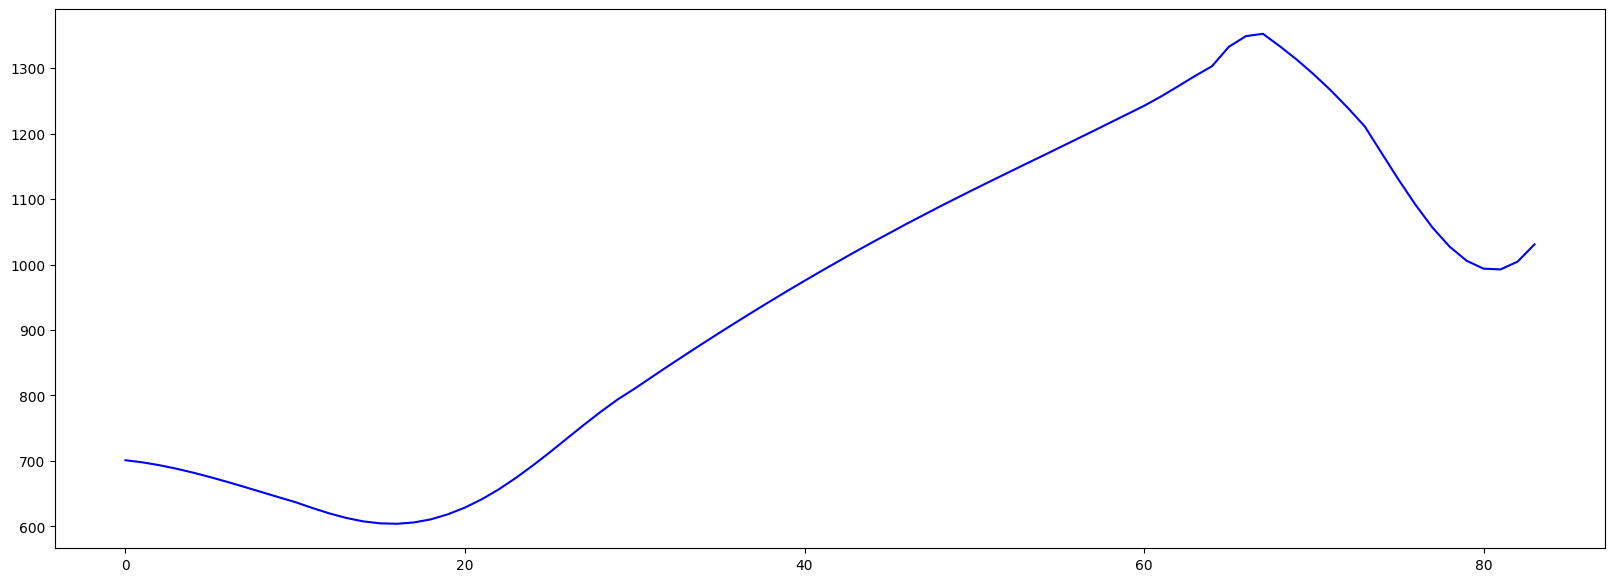

In [71]:
# t_debug_x = [el[0] for el in t_debug]
t_debug_x = [     700.96,      697.75,       693.4,      688.08,      681.95,      675.16,      667.88,      660.27,      652.48,      644.67,      637.02,      628.11,      619.85,      612.85,      607.58,      604.55,      603.88,      605.93,       610.7,      618.41,      628.68,      641.45,      656.65,      673.98,
            693.01,      713.12,      734.09,       754.9,      775.09,      793.95,      810.49,      828.02,      845.37,      862.41,      879.24,      895.87,      912.21,      928.33,      944.18,      959.83,      975.12,       990.2,        1005,      1019.7,        1034,        1048,        1062,      1075.5,
              1089,      1102.1,      1115.1,      1127.9,      1140.6,      1153.3,      1165.8,      1178.5,      1191.2,      1203.9,      1216.8,      1229.6,      1242.5,      1256.8,      1272.3,      1288.1,        1303,      1332.8,        1349,      1352.6,      1333.5,        1313,      1290.5,      1266.1,
            1239.5,      1211.1,      1170.1,      1129.4,      1090.9,      1056.2,      1027.3,      1005.8,      993.65,      992.57,      1004.4,      1030.8]
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(t_debug_x, color='blue', label='x')

In [66]:
print(real_extrema_x_idx)
print(real_maxima_y)

[0, 70, 134, 185, 251, 301, 365, 411, 480, 527, 596, 641, 702, 749, 818, 860, 930, 1006, 1039, 1081, 2195, 799]
[109, 177, 237, 293, 355, 398, 467, 511, 582, 634, 693, 739, 802, 854, 915, 966, 1030, 1076, 1153, 2212]


In [ ]:
tmp = ls_ball_cy[92:186]

# Test linh tinh

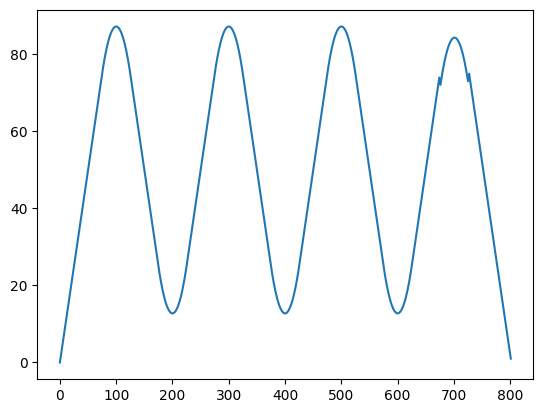

In [24]:
from scipy.signal import savgol_filter

# tmp = [1, 100, 100, 200] + list(range(2, 100))
tmp = list(range(0, 100)) + list(range(100, 0, -1))
tmp = tmp + tmp + tmp
tmp_outlier = list(range(0, 100)) + [0, 2] + list(range(100, 0, -1))
tmp = tmp + tmp_outlier

# smooth
tmp = savgol_filter(tmp, 51, 1)

# line plot
import matplotlib.pyplot as plt
plt.plot(tmp)
plt.show()